### TO DO: update likelihood estimate if sampler is stuck for more than 20 (or something) steps.


In [1]:
# Calling libraries:
from __future__ import division
%matplotlib inline
import numpy as np, time, matplotlib.pyplot as plt, math, pandas, numpy.random as npr
from pylab import plot, show, legend
from time import time
from scipy.stats import *
from Ricker_functions import *

In [2]:
x_0 = 5 
T = 500
r, sigma, phi = np.exp(2.8), 0.5, 3
theta = np.asarray([r, sigma, phi])

X, Y = simulate_data(x_0, T, theta)

### Does it track?

* Start at wrong positions

(50, 101)

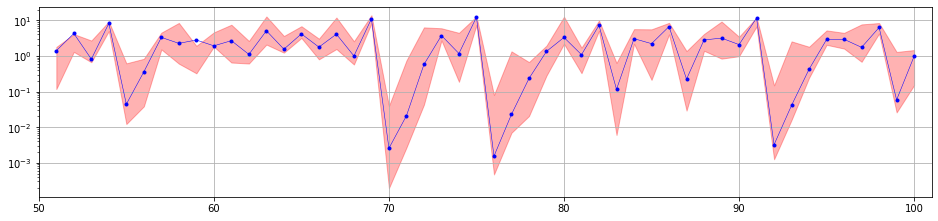

In [3]:
N_PF = 1_000
initial = np.exp(10*npr.randn(N_PF))
t_start, t_end = 50, 100
logNC, particles, weights = bootstrap_PF(initial, N_PF, theta, Y[t_start:t_end]) 

plt.rcParams['figure.figsize'] = (16, 3.5)
plt.plot(1+np.arange(t_start,t_end), X[t_start:t_end], 'bo-', markersize=3, lw=0.5)
plt.fill_between(1+np.arange(t_start,t_end), np.percentile(particles[1:],axis=1,q=5), 
                 np.percentile(particles[1:],axis=1,q=95), color='red', alpha=.3)
plt.grid(True)
plt.yscale('log')
plt.xlim(t_start,t_end+1)

In [4]:
logNC

-125.02763278492317

### Particle MCMC sanity checks:

100%|██████████| 10000/10000 [00:58<00:00, 170.86it/s]


33.73 % acceptance rate


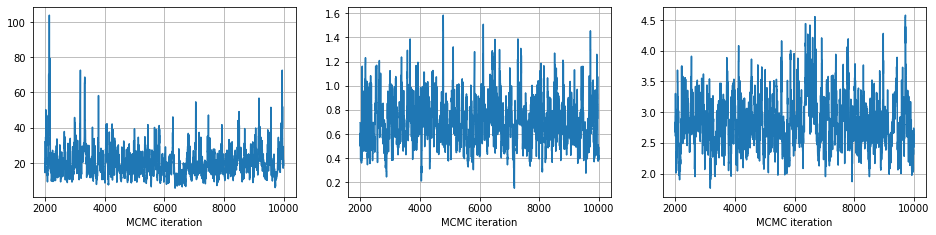

In [6]:
n_mcmc = 10_000
n_pf = 50
power = 1
scale = np.asarray([0.25713415, 0.18920668, 0.10189114])/np.sqrt(power)
theta_chain_nopower, scales_nopower = pMCMC(x_0, Y[50:100], theta, n_pf, n_mcmc, scale, power=power, adapt=True, start_adapt=0.2)

burnin = 2000
plt.rcParams['figure.figsize'] = (16, 3.5)
for i in range(3) :
    plt.subplot(1,3,i+1)
    plt.plot(np.arange(burnin-1,n_mcmc), theta_chain_nopower[burnin:,i])
    plt.grid(True)
    plt.xlabel("MCMC iteration")

In [7]:
scales_nopower[-1]

array([0.26792648, 0.19300205, 0.10450302])

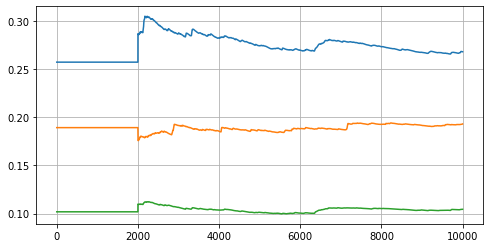

In [8]:
plt.rcParams['figure.figsize'] = (8, 4)
for i in range(3) :
    plt.plot(scales_nopower[:,i])
plt.grid(True)

100%|██████████| 10000/10000 [01:05<00:00, 153.59it/s]


32.39 % acceptance rate


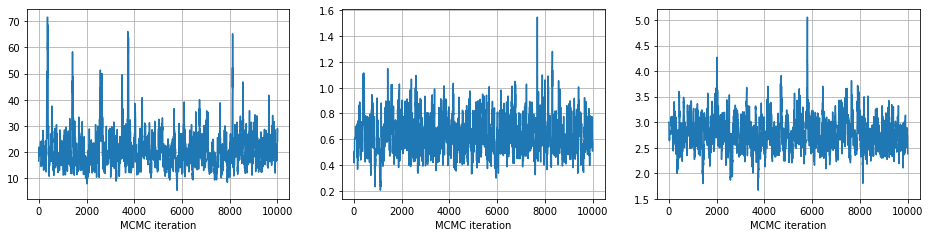

In [9]:
n_mcmc = 10_000
power = 2
n_pf = power*50
scale = np.asarray([0.25713415, 0.18920668, 0.10189114])/np.sqrt(power)
theta_chain_pow2, scales_pow2 = pMCMC(x_0, Y[50:100], theta, n_pf, n_mcmc, scale, power=power, adapt=True, start_adapt=0.2)

burnin = 2000
plt.rcParams['figure.figsize'] = (16, 3.5)
for i in range(3) :
    plt.subplot(1,3,i+1)
    plt.plot(np.arange(n_mcmc+1), theta_chain_pow2[:,i])
    plt.grid(True)
    plt.xlabel("MCMC iteration")

100%|██████████| 10000/10000 [01:24<00:00, 118.32it/s]


33.81 % acceptance rate


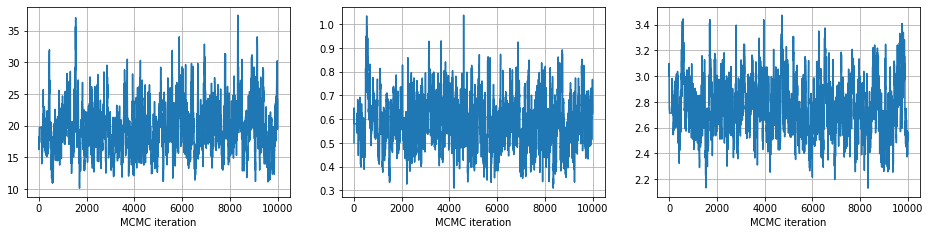

In [10]:
n_mcmc = 10_000
power = 5
n_pf = power*50
scale = np.asarray([0.25713415, 0.18920668, 0.10189114])/np.sqrt(power)
theta_chain_pow5, scales_pow5 = pMCMC(x_0, Y[50:100], theta, n_pf, n_mcmc, scale, power=power, adapt=True, start_adapt=0.2)

burnin = 2000

plt.rcParams['figure.figsize'] = (16, 3.5)
for i in range(3) :
    plt.subplot(1,3,i+1)
    plt.plot(np.arange(n_mcmc+1), theta_chain_pow5[:,i])
    plt.grid(True)
    plt.xlabel("MCMC iteration")

In [11]:
print(np.mean(theta_chain_nopower,0))
print(np.mean(theta_chain_pow2,0))
print(np.mean(theta_chain_pow5,0))
print(theta)

[20.27012357  0.69901469  2.83925379]
[20.23815437  0.62685253  2.7800378 ]
[19.47224271  0.58339514  2.75537062]
[16.44464677  0.5         3.        ]


### Divide-and-conquer MCMC:

In [12]:
N_init = 5000
adapt = True
start_adapt = 0.2

In [13]:
n_mcmc = 10_000
chunk_size = 100
n_pf = T
power = T/chunk_size
scale = np.asarray([0.25713415, 0.18920668, 0.10189114])/np.sqrt(10)

theta_chain_dc = chunked_pMCMC(x_0, Y, theta, n_mcmc, scale, n_pf, chunk_size, 
                               power=power, N_init=5000, adapt=True, start_adapt=0.2)

  0%|          | 8/10000 [00:00<02:20, 71.27it/s]

29.95 % acceptance rate


  0%|          | 8/10000 [00:00<02:12, 75.51it/s]

31.83 % acceptance rate


  0%|          | 8/10000 [00:00<02:16, 72.94it/s]

30.33 % acceptance rate


  0%|          | 8/10000 [00:00<02:17, 72.91it/s]

29.53 % acceptance rate


100%|██████████| 10000/10000 [03:54<00:00, 42.56it/s]

30.28 % acceptance rate


100%|██████████| 10000/10000 [19:13<00:00,  8.63it/s]


31.09 % acceptance rate


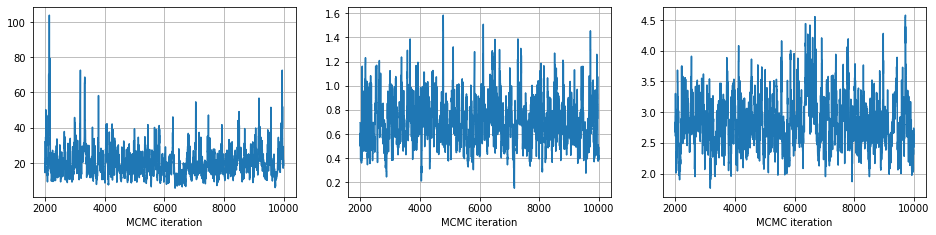

In [14]:
n_mcmc = 10_000
n_pf = T
scale = np.asarray([0.25713415, 0.18920668, 0.10189114])/np.sqrt(10)
theta_chain_full, scales_full = pMCMC(x_0, Y, theta, n_pf, n_mcmc, scale, power=1, adapt=True, start_adapt=0.2)

burnin = 2000
plt.rcParams['figure.figsize'] = (16, 3.5)
for i in range(3) :
    plt.subplot(1,3,i+1)
    plt.plot(np.arange(burnin-1,n_mcmc), theta_chain_nopower[burnin:,i])
    plt.grid(True)
    plt.xlabel("MCMC iteration")

In [15]:
print(np.mean(np.mean(theta_chain_dc,1),0))
print(np.mean(theta_chain_full,0))

[16.98017695  0.54809998  2.96978013]
[16.66149771  0.55846244  2.96853405]


In [16]:
print(np.mean(np.median(theta_chain_dc,1),0))
print(np.median(theta_chain_full,0))

[16.80230702  0.54509258  2.95887327]
[16.49939571  0.55707091  2.96607557]


In [17]:
np.shape(theta_chain_dc)

(5, 10001, 3)

In [22]:
print(np.mean(np.percentile(theta_chain_dc,q=2.5,axis=1),0))
print(np.mean(np.percentile(theta_chain_dc,q=97.5,axis=1),0))

[11.8940075   0.39344288  2.60381491]
[23.11040358  0.71200547  3.38798699]


In [24]:
print(np.percentile(theta_chain_full,axis=0,q=2.5))
print(np.percentile(theta_chain_full,axis=0,q=97.5))

[12.840137    0.44814508  2.68685472]
[21.18666252  0.68000394  3.27281732]


In [30]:
dc_ci = np.mean(np.percentile(theta_chain_dc, q=[2.5,97.5], axis=1), 1)
full_ci = np.percentile(theta_chain_full, q=[2.5,97.5], axis=0)

In [33]:
dc_ci[1]-dc_ci[0]

array([11.21639608,  0.31856259,  0.78417208])

In [35]:
full_ci[1]-full_ci[0]

array([8.34652552, 0.23185886, 0.5859626 ])